In [1]:
#required packages
!pip install pandas numpy scikit-learn matplotlib seaborn


Loading transaction data...
Loaded 100000 transactions
Preprocessing data...
Engineering features...
Calculating credit scores...
Analyzing credit scores...


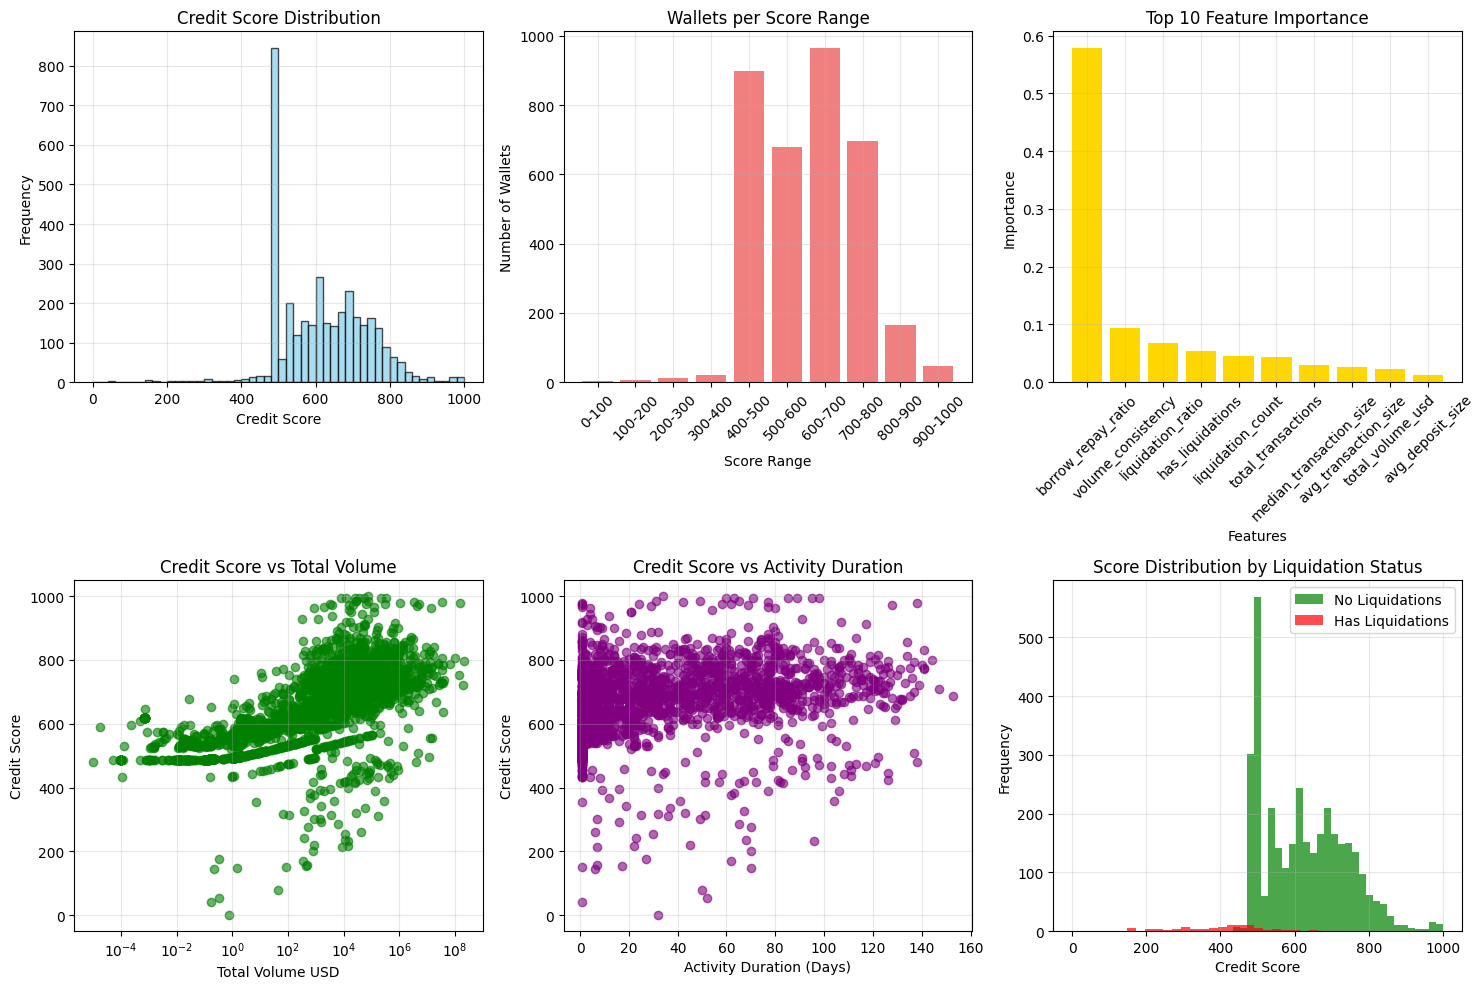


=== CREDIT SCORING ANALYSIS ===
Total wallets scored: 3497
Average credit score: 616.75
Median credit score: 611.11
Score standard deviation: 120.98
Score range: 0.00 - 1000.00

=== SCORE DISTRIBUTION ===
0-100: 4 wallets (0.1%)
100-200: 7 wallets (0.2%)
200-300: 12 wallets (0.3%)
300-400: 20 wallets (0.6%)
400-500: 899 wallets (25.7%)
500-600: 680 wallets (19.4%)
600-700: 965 wallets (27.6%)
700-800: 698 wallets (20.0%)
800-900: 165 wallets (4.7%)
900-1000: 47 wallets (1.3%)

=== LOW SCORE WALLETS (< 300) ===
Count: 23
Average liquidation ratio: 0.336
Average bot score: 0.000
Percentage with liquidations: 100.0%

=== HIGH SCORE WALLETS (> 700) ===
Count: 910
Average volume USD: $1,987,524.36
Average activity duration: 45.1 days
Average borrow-repay ratio: 1.182
Results saved to wallet_credit_scores.csv

=== SAMPLE RESULTS ===
                                      userWallet  credit_score
1787  0x0305cf6d8af11679eee6aa68c528ed25f837aa4f   1000.000000
230   0x0057bd83a142da84b6404616c6

In [2]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class AaveCreditScorer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.feature_columns = []

    def load_data(self, file_path):
        print("Loading transaction data...")
        with open(file_path, 'r') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        print(f"Loaded {len(df)} transactions")
        return df

    def preprocess_data(self, df):
        print("Preprocessing data...")
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        df['amount_float'] = df['actionData'].apply(lambda x: float(x.get('amount', 0)))
        df['asset_price_usd'] = df['actionData'].apply(lambda x: float(x.get('assetPriceUSD', 0)))
        df['asset_symbol'] = df['actionData'].apply(lambda x: x.get('assetSymbol', ''))
        df['usd_value'] = df['amount_float'] * df['asset_price_usd']
        df['normalized_amount'] = df.apply(self._normalize_amount, axis=1)
        df['normalized_usd_value'] = df['normalized_amount'] * df['asset_price_usd']
        return df

    def _normalize_amount(self, row):
        amount = row['amount_float']
        symbol = row['asset_symbol']
        decimals = {
            'USDC': 6, 'USDT': 6, 'DAI': 18, 'WMATIC': 18,
            'WETH': 18, 'WBTC': 8, 'AAVE': 18
        }
        decimal_places = decimals.get(symbol, 18)
        return amount / (10 ** decimal_places)

    def engineer_features(self, df):
        print("Engineering features...")
        wallet_features = []
        for wallet in df['userWallet'].unique():
            wallet_data = df[df['userWallet'] == wallet].copy()
            wallet_data = wallet_data.sort_values('datetime')
            features = self._calculate_wallet_features(wallet_data)
            features['userWallet'] = wallet
            wallet_features.append(features)
        feature_df = pd.DataFrame(wallet_features)
        return feature_df

    def _calculate_wallet_features(self, wallet_data):
        features = {}
        features['total_transactions'] = len(wallet_data)
        features['unique_assets'] = wallet_data['asset_symbol'].nunique()
        features['total_volume_usd'] = wallet_data['normalized_usd_value'].sum()
        features['avg_transaction_size'] = wallet_data['normalized_usd_value'].mean()
        features['median_transaction_size'] = wallet_data['normalized_usd_value'].median()
        date_range = (wallet_data['datetime'].max() - wallet_data['datetime'].min()).days
        features['activity_duration_days'] = max(date_range, 1)
        features['transactions_per_day'] = features['total_transactions'] / features['activity_duration_days']
        action_counts = wallet_data['action'].value_counts()
        total_actions = len(wallet_data)
        features['deposit_ratio'] = action_counts.get('deposit', 0) / total_actions
        features['borrow_ratio'] = action_counts.get('borrow', 0) / total_actions
        features['repay_ratio'] = action_counts.get('repay', 0) / total_actions
        features['redeem_ratio'] = action_counts.get('redeemunderlying', 0) / total_actions
        features['liquidation_ratio'] = action_counts.get('liquidationcall', 0) / total_actions
        features['liquidation_count'] = action_counts.get('liquidationcall', 0)
        features['has_liquidations'] = 1 if features['liquidation_count'] > 0 else 0
        features['transaction_regularity'] = self._calculate_regularity(wallet_data)
        features['volume_consistency'] = self._calculate_volume_consistency(wallet_data)
        borrow_data = wallet_data[wallet_data['action'] == 'borrow']
        repay_data = wallet_data[wallet_data['action'] == 'repay']
        if len(borrow_data) > 0 and len(repay_data) > 0:
            features['borrow_repay_ratio'] = len(repay_data) / len(borrow_data)
            features['avg_borrow_size'] = borrow_data['normalized_usd_value'].mean()
            features['avg_repay_size'] = repay_data['normalized_usd_value'].mean()
        else:
            features['borrow_repay_ratio'] = 0
            features['avg_borrow_size'] = 0
            features['avg_repay_size'] = 0
        deposit_data = wallet_data[wallet_data['action'] == 'deposit']
        if len(deposit_data) > 0:
            features['avg_deposit_size'] = deposit_data['normalized_usd_value'].mean()
            features['deposit_frequency'] = len(deposit_data) / features['activity_duration_days']
        else:
            features['avg_deposit_size'] = 0
            features['deposit_frequency'] = 0
        features['bot_score'] = self._calculate_bot_score(wallet_data)
        return features

    def _calculate_regularity(self, wallet_data):
        if len(wallet_data) < 2:
            return 0
        time_diffs = wallet_data['datetime'].diff().dt.total_seconds().dropna()
        if len(time_diffs) == 0:
            return 0
        return np.std(time_diffs) / np.mean(time_diffs) if np.mean(time_diffs) > 0 else 0

    def _calculate_volume_consistency(self, wallet_data):
        volumes = wallet_data['normalized_usd_value']
        if len(volumes) < 2:
            return 0
        return 1 / (1 + np.std(volumes) / np.mean(volumes)) if np.mean(volumes) > 0 else 0

    def _calculate_bot_score(self, wallet_data):
        bot_indicators = 0
        if len(wallet_data) > 5:
            time_diffs = wallet_data['datetime'].diff().dt.total_seconds().dropna()
            if len(time_diffs) > 0:
                regularity = np.std(time_diffs) / np.mean(time_diffs) if np.mean(time_diffs) > 0 else 0
                if regularity < 0.1:
                    bot_indicators += 1
        if wallet_data['normalized_usd_value'].nunique() / len(wallet_data) < 0.3:
            bot_indicators += 1
        if len(wallet_data) > 100:
            bot_indicators += 1
        return bot_indicators / 3

    def calculate_credit_scores(self, feature_df):
        print("Calculating credit scores...")
        rule_scores = self._calculate_rule_based_scores(feature_df)
        ml_scores = self._calculate_ml_scores(feature_df)
        final_scores = 0.4 * rule_scores + 0.6 * ml_scores
        min_score, max_score = final_scores.min(), final_scores.max()
        scaled_scores = ((final_scores - min_score) / (max_score - min_score)) * 1000
        return scaled_scores

    def _calculate_rule_based_scores(self, feature_df):
        scores = np.zeros(len(feature_df))
        for i, row in feature_df.iterrows():
            score = 500
            if row['total_volume_usd'] > 1000:
                score += 50
            if row['activity_duration_days'] > 30:
                score += 30
            if row['borrow_repay_ratio'] > 0.8:
                score += 40
            if row['deposit_ratio'] > 0.3:
                score += 20
            if row['unique_assets'] > 2:
                score += 15
            if row['volume_consistency'] > 0.5:
                score += 25
            if row['has_liquidations']:
                score -= 100
            if row['bot_score'] > 0.5:
                score -= 80
            if row['transaction_regularity'] < 0.1 and row['total_transactions'] > 10:
                score -= 50
            if row['liquidation_ratio'] > 0.1:
                score -= 150
            scores[i] = max(0, min(1000, score))
        return scores

    def _calculate_ml_scores(self, feature_df):
        target = self._create_synthetic_target(feature_df)
        feature_cols = [col for col in feature_df.columns if col != 'userWallet']
        X = feature_df[feature_cols].fillna(0)
        self.model.fit(X, target)
        predictions = self.model.predict(X)
        min_pred, max_pred = predictions.min(), predictions.max()
        if max_pred > min_pred:
            scaled_predictions = ((predictions - min_pred) / (max_pred - min_pred)) * 1000
        else:
            scaled_predictions = np.full_like(predictions, 500)
        return scaled_predictions

    def _create_synthetic_target(self, feature_df):
        target = np.zeros(len(feature_df))
        for i, row in feature_df.iterrows():
            score = 500
            score += np.log1p(row['total_volume_usd']) * 10
            score += np.log1p(row['activity_duration_days']) * 5
            score += row['borrow_repay_ratio'] * 100
            score += row['deposit_ratio'] * 50
            score += row['volume_consistency'] * 100
            score -= row['has_liquidations'] * 200
            score -= row['bot_score'] * 150
            score -= row['liquidation_ratio'] * 300
            target[i] = max(0, min(1000, score))
        return target

    def analyze_scores(self, feature_df, scores):
        print("Analyzing credit scores...")
        bins = np.arange(0, 1001, 100)
        bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
        feature_df['score_bin'] = pd.cut(scores, bins=bins, labels=bin_labels, include_lowest=True)
        feature_df['credit_score'] = scores
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1)
        plt.hist(scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('Credit Score')
        plt.ylabel('Frequency')
        plt.title('Credit Score Distribution')
        plt.grid(True, alpha=0.3)
        plt.subplot(2, 3, 2)
        score_bin_counts = feature_df['score_bin'].value_counts().sort_index()
        plt.bar(range(len(score_bin_counts)), score_bin_counts.values, color='lightcoral')
        plt.xlabel('Score Range')
        plt.ylabel('Number of Wallets')
        plt.title('Wallets per Score Range')
        plt.xticks(range(len(score_bin_counts)), score_bin_counts.index, rotation=45)
        plt.grid(True, alpha=0.3)
        if hasattr(self.model, 'feature_importances_'):
            plt.subplot(2, 3, 3)
            feature_cols = [col for col in feature_df.columns if col not in ['userWallet', 'score_bin', 'credit_score']]
            importances = self.model.feature_importances_
            indices = np.argsort(importances)[::-1][:10]
            plt.bar(range(len(indices)), importances[indices], color='gold')
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.title('Top 10 Feature Importance')
            plt.xticks(range(len(indices)), [feature_cols[i] for i in indices], rotation=45)
            plt.grid(True, alpha=0.3)
        plt.subplot(2, 3, 4)
        plt.scatter(feature_df['total_volume_usd'], scores, alpha=0.6, color='green')
        plt.xlabel('Total Volume USD')
        plt.ylabel('Credit Score')
        plt.title('Credit Score vs Total Volume')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        plt.subplot(2, 3, 5)
        plt.scatter(feature_df['activity_duration_days'], scores, alpha=0.6, color='purple')
        plt.xlabel('Activity Duration (Days)')
        plt.ylabel('Credit Score')
        plt.title('Credit Score vs Activity Duration')
        plt.grid(True, alpha=0.3)
        plt.subplot(2, 3, 6)
        liquidated = feature_df[feature_df['has_liquidations'] == 1]['credit_score']
        non_liquidated = feature_df[feature_df['has_liquidations'] == 0]['credit_score']
        plt.hist(non_liquidated, bins=30, alpha=0.7, label='No Liquidations', color='green')
        plt.hist(liquidated, bins=30, alpha=0.7, label='Has Liquidations', color='red')
        plt.xlabel('Credit Score')
        plt.ylabel('Frequency')
        plt.title('Score Distribution by Liquidation Status')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print("\n=== CREDIT SCORING ANALYSIS ===")
        print(f"Total wallets scored: {len(feature_df)}")
        print(f"Average credit score: {scores.mean():.2f}")
        print(f"Median credit score: {np.median(scores):.2f}")
        print(f"Score standard deviation: {scores.std():.2f}")
        print(f"Score range: {scores.min():.2f} - {scores.max():.2f}")
        print("\n=== SCORE DISTRIBUTION ===")
        for bin_label, count in score_bin_counts.items():
            percentage = (count / len(feature_df)) * 100
            print(f"{bin_label}: {count} wallets ({percentage:.1f}%)")
        low_score_wallets = feature_df[feature_df['credit_score'] < 300]
        print(f"\n=== LOW SCORE WALLETS (< 300) ===")
        print(f"Count: {len(low_score_wallets)}")
        if len(low_score_wallets) > 0:
            print(f"Average liquidation ratio: {low_score_wallets['liquidation_ratio'].mean():.3f}")
            print(f"Average bot score: {low_score_wallets['bot_score'].mean():.3f}")
            print(f"Percentage with liquidations: {(low_score_wallets['has_liquidations'].sum() / len(low_score_wallets)) * 100:.1f}%")
        high_score_wallets = feature_df[feature_df['credit_score'] > 700]
        print(f"\n=== HIGH SCORE WALLETS (> 700) ===")
        print(f"Count: {len(high_score_wallets)}")
        if len(high_score_wallets) > 0:
            print(f"Average volume USD: ${high_score_wallets['total_volume_usd'].mean():,.2f}")
            print(f"Average activity duration: {high_score_wallets['activity_duration_days'].mean():.1f} days")
            print(f"Average borrow-repay ratio: {high_score_wallets['borrow_repay_ratio'].mean():.3f}")
        return feature_df

    def save_results(self, feature_df, output_file='wallet_credit_scores.csv'):
        output_df = feature_df[['userWallet', 'credit_score']].copy()
        output_df = output_df.sort_values('credit_score', ascending=False)
        output_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
        return output_df

def main():
    scorer = AaveCreditScorer()
    file_path = '/content/user-wallet-transactions.json'
    try:
        df = scorer.load_data(file_path)
    except:
        print("Using sample data for demonstration...")
        df = pd.DataFrame(sample_data)
    df = scorer.preprocess_data(df)
    feature_df = scorer.engineer_features(df)
    scores = scorer.calculate_credit_scores(feature_df)
    final_df = scorer.analyze_scores(feature_df, scores)
    output_df = scorer.save_results(final_df)
    print("\n=== SAMPLE RESULTS ===")
    print(output_df.head(10))
    return scorer, final_df

if __name__ == "__main__":
    scorer, results = main()